In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (fbeta_score, f1_score, precision_score, recall_score,classification_report,ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, make_scorer, accuracy_score)

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from collections import Counter

In [ ]:
##Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Change the current working directory
os.chdir('/content/gdrive/My Drive/QML')

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /content/gdrive/My Drive/QML


In [ ]:
######### Load Dataset ############
df=pd.read_csv('card.csv')

# Basic Info

In [ ]:
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,94.689486,0.212096,2.379196,1,0,0,0,0
1,2.148094,3.631258,0.867552,1,1,0,1,0
2,8.201513,0.196793,0.568646,1,0,0,1,0
3,1.813192,0.613588,0.749469,0,1,0,1,0
4,26.211924,4.871637,1.610984,1,0,1,1,0


In [ ]:
df.shape

(100000, 8)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
distance_from_home,100000.0,26.590820,64.650722,0.024602,3.862610,9.927395,25.748508,5797.972589
distance_from_last_transaction,100000.0,5.014137,27.936610,0.000434,0.292248,0.991747,3.349950,4968.315477
ratio_to_median_purchase_price,100000.0,1.840082,2.853822,0.007427,0.476066,1.003489,2.108224,126.294930
repeat_retailer,100000.0,0.880570,0.324295,0.000000,1.000000,1.000000,1.000000,1.000000
used_chip,100000.0,0.349030,0.476666,0.000000,0.000000,0.000000,1.000000,1.000000
used_pin_number,100000.0,0.101290,0.301714,0.000000,0.000000,0.000000,0.000000,1.000000
online_order,100000.0,0.651040,0.476644,0.000000,0.000000,1.000000,1.000000,1.000000
fraud,100000.0,0.087400,0.282422,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
df.isnull().sum()

,0
distance_from_home,0
distance_from_last_transaction,0
ratio_to_median_purchase_price,0
repeat_retailer,0
used_chip,0
used_pin_number,0
online_order,0
fraud,0


In [ ]:
df.nunique()

,0
distance_from_home,100000
distance_from_last_transaction,99999
ratio_to_median_purchase_price,99999
repeat_retailer,2
used_chip,2
used_pin_number,2
online_order,2
fraud,2


# EDA


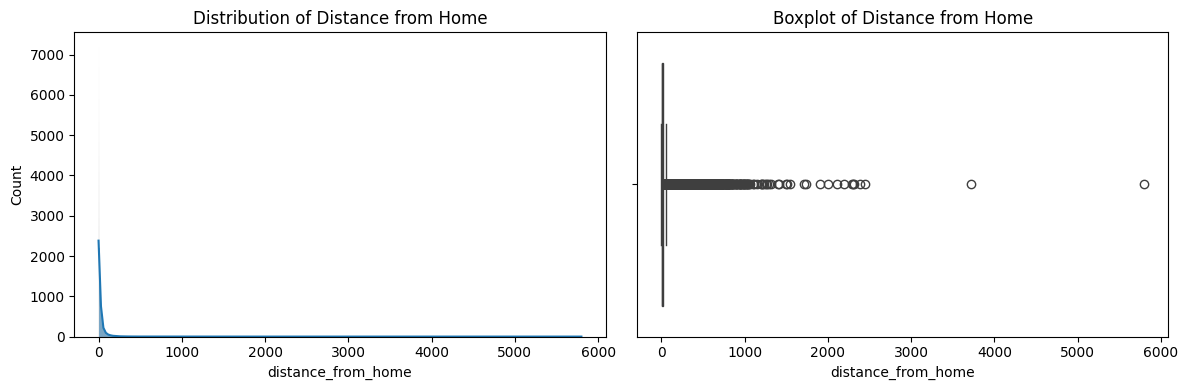

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution (Histogram + KDE)
sns.histplot(df['distance_from_home'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Distance from Home')

# Boxplot
sns.boxplot(x=df['distance_from_home'], ax=axes[1])
axes[1].set_title('Boxplot of Distance from Home')

plt.tight_layout()
plt.show()


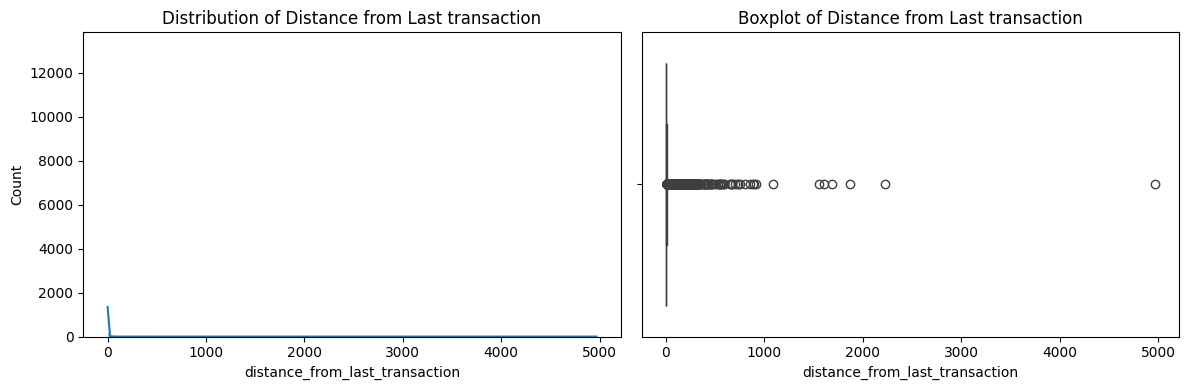

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution (Histogram + KDE)
sns.histplot(df['distance_from_last_transaction'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Distance from Last transaction')

# Boxplot
sns.boxplot(x=df['distance_from_last_transaction'], ax=axes[1])
axes[1].set_title('Boxplot of Distance from Last transaction')

plt.tight_layout()
plt.show()


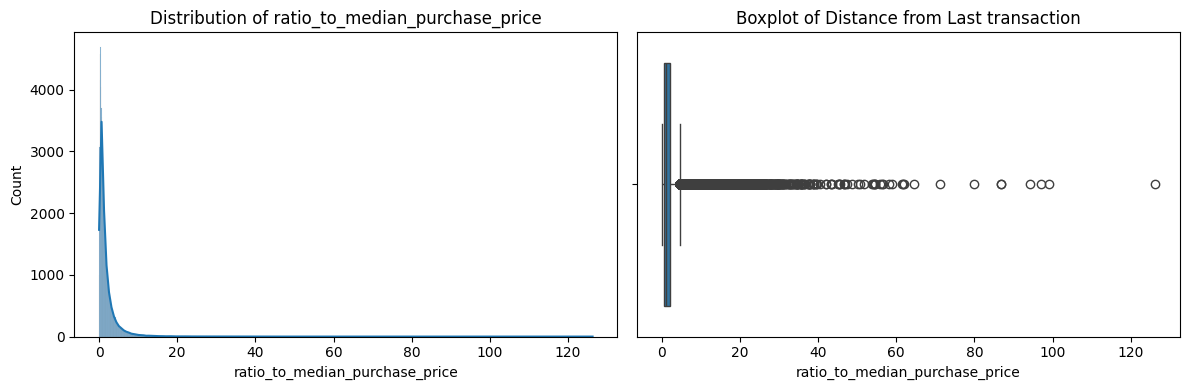

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribution (Histogram + KDE)
sns.histplot(df['ratio_to_median_purchase_price'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of ratio_to_median_purchase_price')

# Boxplot
sns.boxplot(x=df['ratio_to_median_purchase_price'], ax=axes[1])
axes[1].set_title('Boxplot of Distance from Last transaction')

plt.tight_layout()
plt.show()


The Variables distance_from_home, distance_last_transaction and ratio_to_median_purchase_price are heavily right-skewed and needs log transformation

In [ ]:
df['log_distance_from_home'] = np.log1p(df['distance_from_home'])

In [ ]:
df['log_distance_last_transaction'] = np.log1p(df['distance_from_last_transaction'])

In [ ]:
df['log_ratio_to_median_purchase_price'] = np.log1p(df['ratio_to_median_purchase_price'])

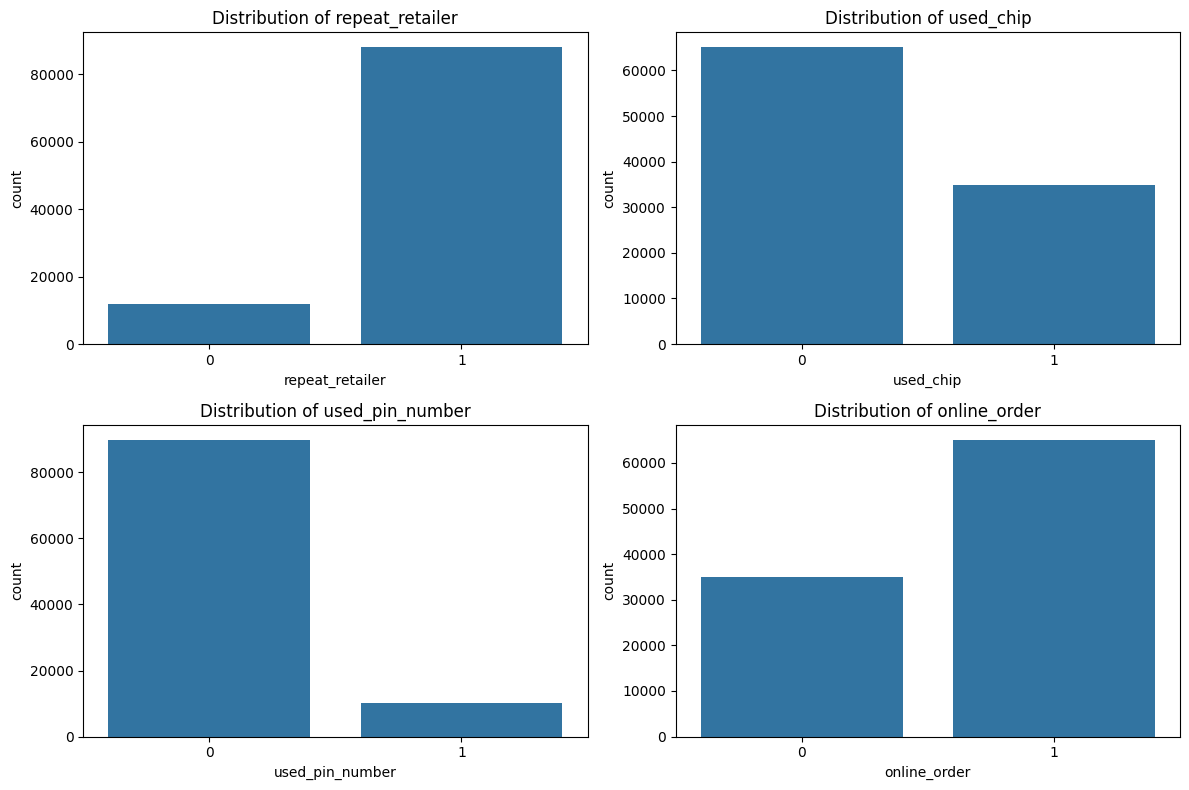

In [ ]:
categorical_cols = ['repeat_retailer','used_chip','used_pin_number','online_order']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


In [ ]:
df['fraud'].value_counts()


,count
fraud,
0,91260
1,8740


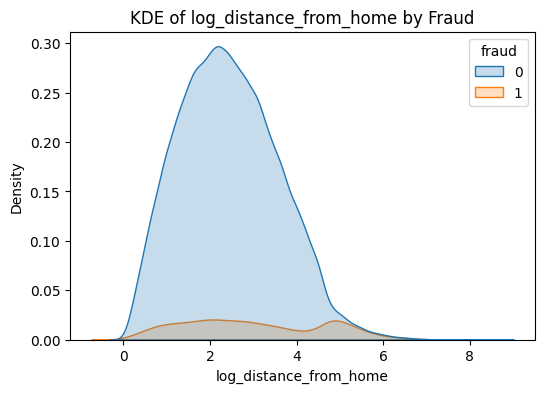

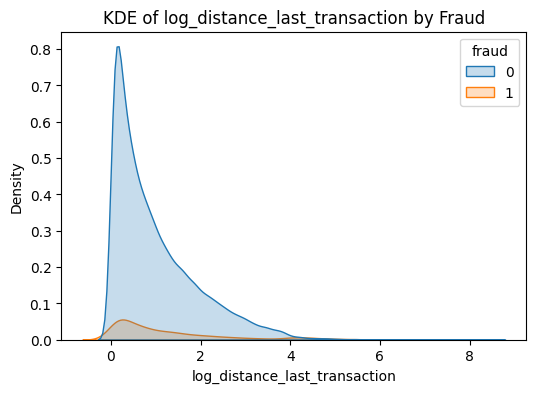

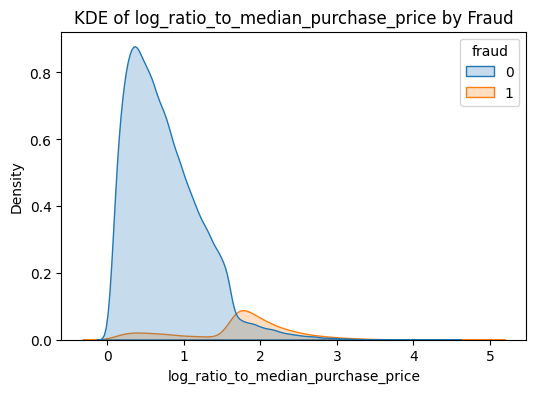

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in [
    'log_distance_from_home',
    'log_distance_last_transaction',
    'log_ratio_to_median_purchase_price'
]:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='fraud', fill=True)
    plt.title(f'KDE of {col} by Fraud')
    plt.show()




In [ ]:
binary_features = [
    "repeat_retailer",
    "used_chip",
    "used_pin_number",
    "online_order"
]

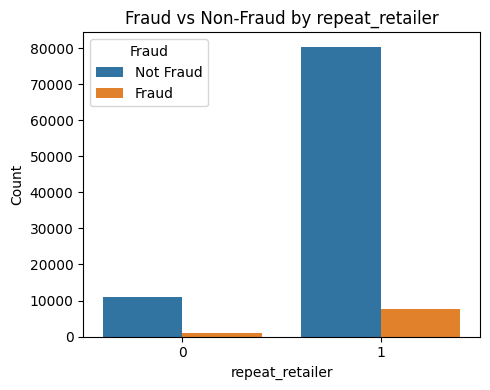

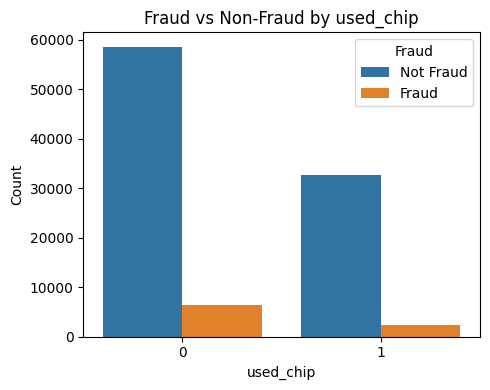

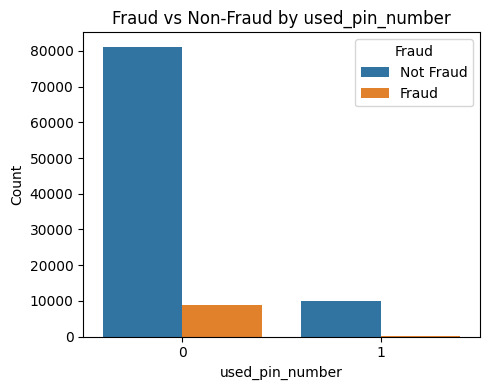

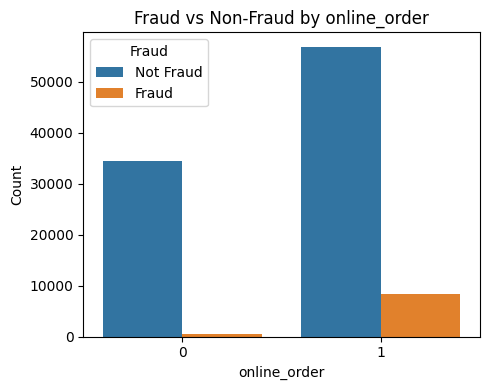

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in binary_features:
    plt.figure(figsize=(5,4))
    sns.countplot(
        data=df,
        x=col,
        hue="fraud"
    )
    plt.title(f"Fraud vs Non-Fraud by {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title="Fraud", labels=["Not Fraud", "Fraud"])
    plt.tight_layout()
    plt.show()


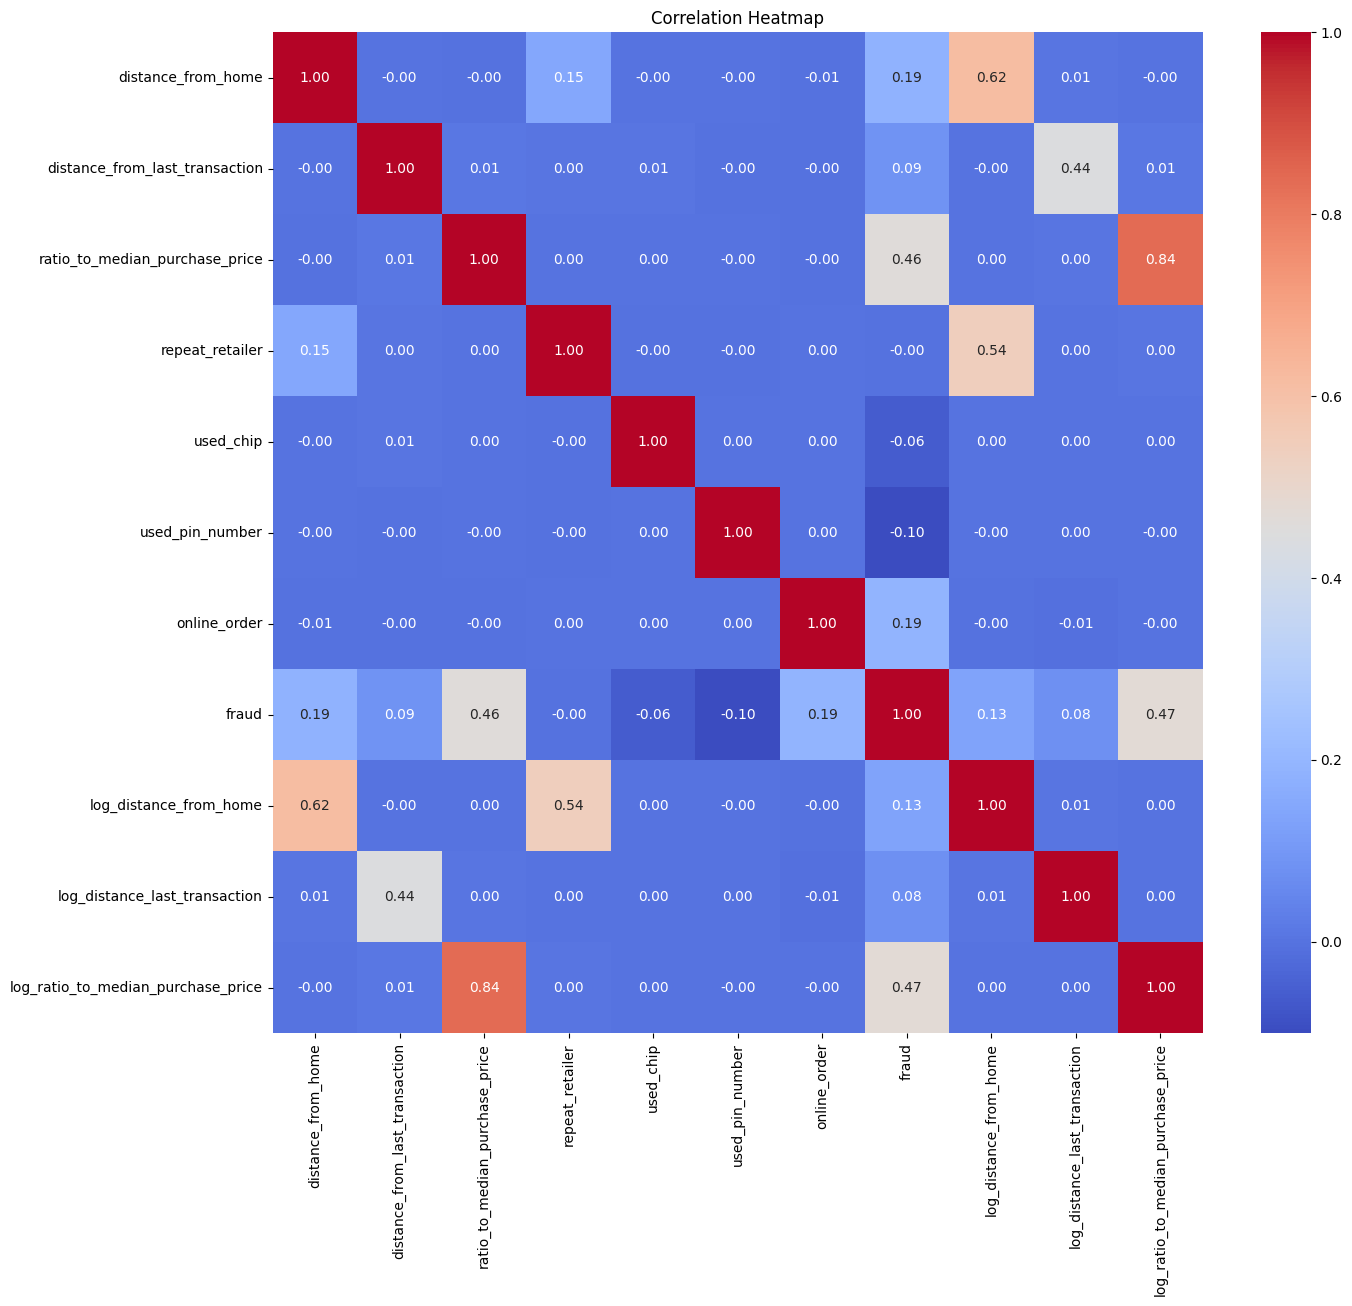

In [ ]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(15,13))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Feature Engineering

In [ ]:
features = [
    'log_distance_from_home',
    'log_distance_last_transaction',
    'log_ratio_to_median_purchase_price',
    'online_order',
    'used_chip',
    'used_pin_number','repeat_retailer'
]


X = df[features]
y = df['fraud']

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X, y)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [ ]:
import pandas as pd

importances = pd.Series(
    rf.feature_importances_,
    index=features
).sort_values(ascending=False)

importances


,0
log_ratio_to_median_purchase_price,0.562336
log_distance_from_home,0.195701
online_order,0.101110
log_distance_last_transaction,0.076146
used_pin_number,0.033211
used_chip,0.023967
repeat_retailer,0.007529


In [ ]:
top_rf_features = importances.head(4).index.tolist()
df[top_rf_features].corr()

,log_ratio_to_median_purchase_price,log_distance_from_home,online_order,log_distance_last_transaction
log_ratio_to_median_purchase_price,1.000000,0.002205,-0.001612,0.000872
log_distance_from_home,0.002205,1.000000,-0.003881,0.005495
online_order,-0.001612,-0.003881,1.000000,-0.009092
log_distance_last_transaction,0.000872,0.005495,-0.009092,1.000000


In [ ]:
final_features = [
    'log_ratio_to_median_purchase_price',
    'log_distance_from_home',
    'log_distance_last_transaction',
    'online_order'
]

X = df[final_features]
y = df['fraud']

final_df = X.copy()
final_df['fraud'] = y

# Export to CSV
final_df.to_csv('final_dataset4.csv', index=False)


In [ ]:
final_features = [
    'log_ratio_to_median_purchase_price',
    'log_distance_from_home',
    'online_order'
]

X = df[final_features]
y = df['fraud']

final_df = X.copy()
final_df['fraud'] = y

# Export to CSV
final_df.to_csv('final_dataset3.csv', index=False)


In [ ]:
final_features = [
    'log_ratio_to_median_purchase_price',
    'log_distance_from_home'
]

X = df[final_features]
y = df['fraud']

final_df = X.copy()
final_df['fraud'] = y

# Export to CSV
final_df.to_csv('final_dataset2.csv', index=False)
